In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr

# import geopandas as gpd

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as PathEffects
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# extras
from IPython.display import Image, display
from PIL import Image
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from ar_funcs import AR_rank

In [2]:
# Set up paths

path_to_data = '/home/dnash/SEAK_clim_data/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures


### Data from all notebooks (TODO: make yaml dict)

In [3]:
ext1 = [-141., -130., 54., 61.] # extent of SEAK 

## six communities
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.8894, 59.3988, Klukwan
# -139.671	59.5121, Yakutat (PAYA)
# -133.1358, 55.4769, Craig
# -132.4009, 55.5400, Kasaan

xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'center'] # where the labels go

## closest station
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.5117	59.2429, Haines (PAHN)
# -139.671	59.5121, Yakutat (PAYA)
# -133.076	55.5792, Klawock (PAKW)
# -131.7117	55.3567, Ketchikan (PAKT)
xs2 = [-135.4519, -135.3277, -135.5117, -139.671, -133.076, -131.7117]
ys2 = [58.1122, 59.4538, 59.2429, 59.5121, 55.5792, 55.3567]
lbl2 = ['PAOH', 'PAGY', 'PAHN', 'PAYA', 'PAKW', 'PAKT']

### Read IVT data

In [4]:
datelst = ['1128', '1129', '1130', '1201', '1202', '1203']
filenames = []
for i, monthday in enumerate(datelst):
    filenames.append('/data/downloaded/Reanalysis/ERA5/IVT/2020/ERA5_IVT_2020{0}.nc'.format(monthday))
    
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(ext1[2], ext1[3]), lon=slice(ext1[0], ext1[1]))

era = xr.open_mfdataset(filenames, preprocess=preprocess, combine='by_coords')

# select the grid cell closest to each of the communities
df_lst = []
row_lbl = []
rank = []
for i, (slon, slat) in enumerate(zip(xs, ys)):
    ds = era.sel(lat=slat, lon=slon, method="nearest")
    df = ds.IVT.to_dataframe()
    df_lst.append(df)
    
    # calculate AR rank
    rank.append(AR_rank(df))
    
    # make nice labels for plot
    lbl = u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}W".format(slat, slon*-1)
    row_lbl.append(lbl)

df_lst[0]

,lat,lon,IVT
time,,,
2020-11-28 00:00:00,58.0,-135.5,21.219994
2020-11-28 01:00:00,58.0,-135.5,32.005680
2020-11-28 02:00:00,58.0,-135.5,48.825709
2020-11-28 03:00:00,58.0,-135.5,66.475656
2020-11-28 04:00:00,58.0,-135.5,86.189076
...,...,...,...
2020-12-03 19:00:00,58.0,-135.5,120.458302
2020-12-03 20:00:00,58.0,-135.5,127.758430
2020-12-03 21:00:00,58.0,-135.5,125.423750


### Plot time series

In [6]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

### Get x-tick and x-labels
x = df.index.values
x_ticks = x

x_labels = []
for j in range(len(x)):
    t = pd.to_datetime(str(x[j]))
    x_labels.append(t.strftime('%m-%d %H'))


### Read ASOS precipitation data

In [13]:
## location and name of txt file
filename = path_to_data + 'downloads/asos.csv'
df = pd.read_csv(filename, header=0, sep=',', engine='python',
                      parse_dates=['valid'])

# Converting the index as date (need to do this to utilize functionality of resample)
df.index = pd.to_datetime(df.valid)
stn_lst = df.station.unique()
# # list column names
# for col in df.columns:
#     print(col)

# p01i:
# one hour precip in inches
# for the period from the observation time to the time of the previous hourly precipitation reset

merge_df_lst = []
for i, stn in enumerate(stn_lst):    
    ## select single station
    idx = df['station'] == stn
    tmp = df[idx]

    ## convert from inches/hour to mm/hour
    tmp['p01i'] = tmp['p01i']*25.4

    ## resample to hourly precipitation
    precip_1hour = tmp['p01i'].resample('1H').max()

    tmp2 = precip_1hour.to_frame()
    tmp2 = tmp2.reset_index() # reset index to merge with IVT
    tmp2 = tmp2.rename(columns={"valid": "time"})
    
    tmp3 = df_lst[i].reset_index()
    
    merged_data = pd.merge(tmp3, tmp2, how='outer', on='time')
    merge_df_lst.append(merged_data)
    

/home/dnash/miniconda3/envs/pyclivac/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
merge_df_lst[1]

,time,lat,lon,IVT,p01i
0,2020-11-28 00:00:00,59.5,-135.25,18.405739,0.0
1,2020-11-28 01:00:00,59.5,-135.25,17.355514,0.0
2,2020-11-28 02:00:00,59.5,-135.25,19.263508,0.0
3,2020-11-28 03:00:00,59.5,-135.25,26.075212,0.0
4,2020-11-28 04:00:00,59.5,-135.25,37.801332,0.0
...,...,...,...,...,...
139,2020-12-03 19:00:00,59.5,-135.25,101.195196,NaN
140,2020-12-03 20:00:00,59.5,-135.25,101.125419,NaN
141,2020-12-03 21:00:00,59.5,-135.25,96.963674,NaN
142,2020-12-03 22:00:00,59.5,-135.25,95.920078,NaN


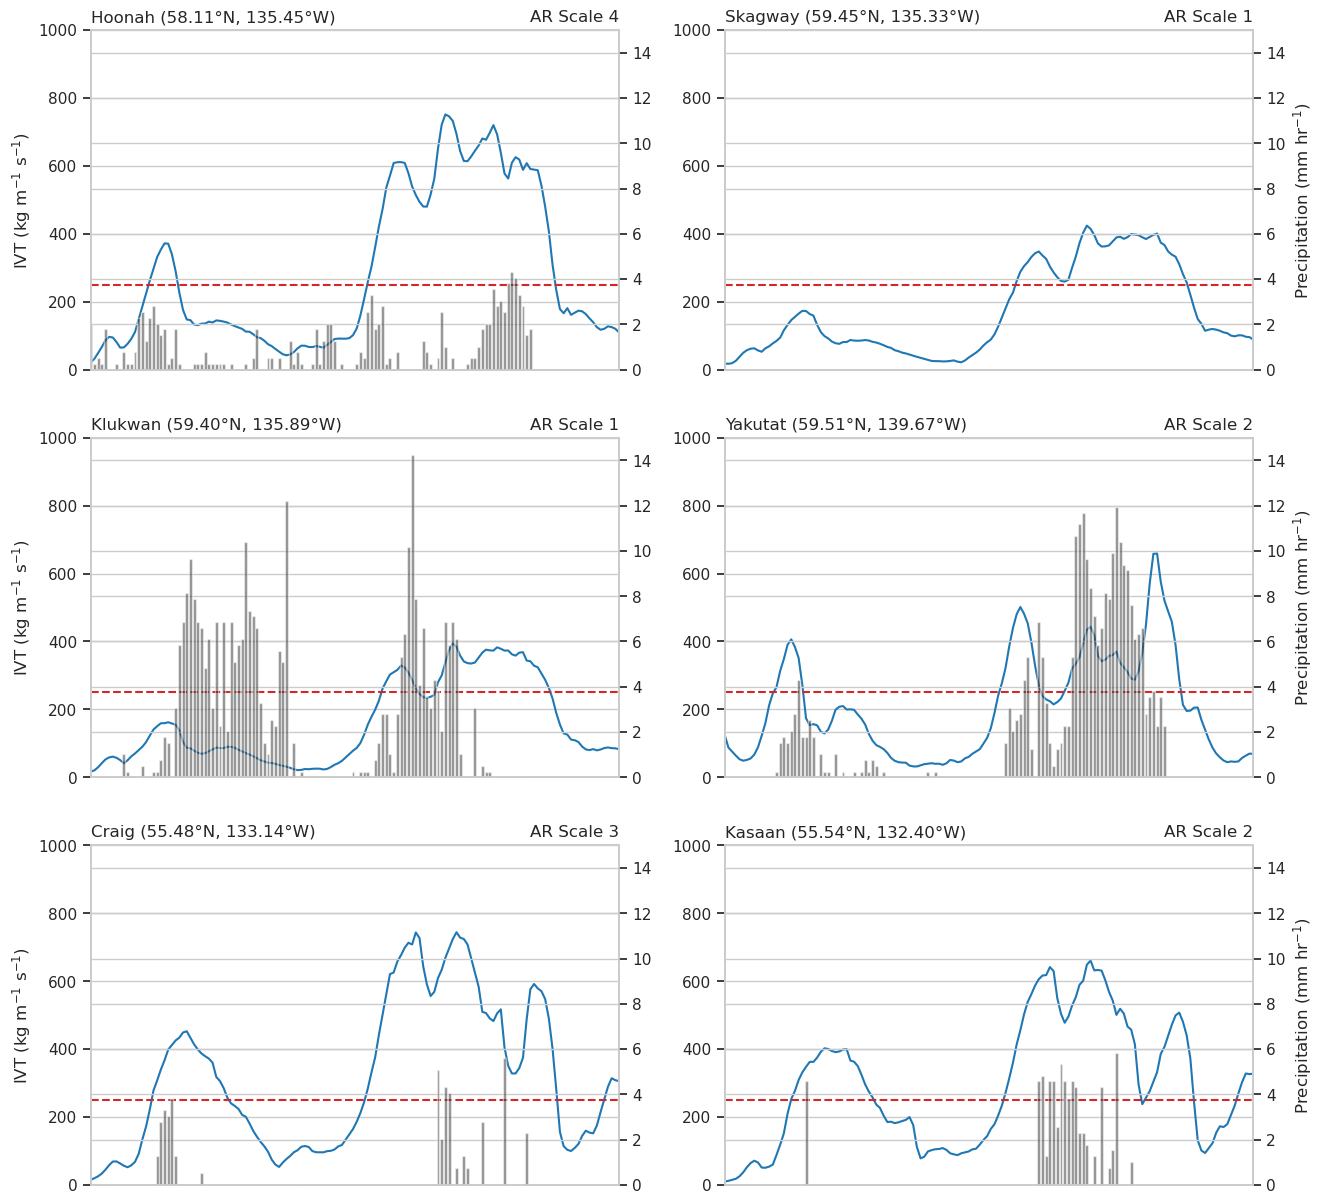

In [18]:
fname = path_to_figs + 'precip-IVT_time_series_dec2020'
fmt = 'png'
nrows = 3
ncols = 2
nplots=nrows*ncols

xaxis_lbl = ['']*4 + ['Date (month-day hour)']*2
ylbl = ['IVT (kg m$^{-1}$ s$^{-1}$)', '']*3
ylbl2 = ['', 'Precipitation (mm hr$^{-1}$)']*3

fig = plt.figure(figsize=(15,15))
sns.set_style("whitegrid")

for i, (df, lbl) in enumerate(zip(merge_df_lst, lbl1)):
    
    ax = fig.add_subplot(nrows, ncols, i+1)
    
    # plot IVT
    ivt = sns.lineplot(x=df.index, y="IVT", data=df, color='tab:blue', ax=ax, label='IVT', legend=False)
    
    # add 250 kg m-1 s-1 threshold
    ax.axhline(y=250.0, color='tab:red', linestyle='--')

    
    ax.set_ylabel(ylbl[i])
    ax.set_ylim(0, 1000)

    ax.set_title(lbl+' ({0})'.format(row_lbl[i]), loc='left')
    ax.set_title('AR Scale {0}'.format(rank[i]), loc='right')
    
    ## add twin axis for precip info
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    prec = sns.barplot(x=df.index, y="p01i", data=df, color='k', alpha=0.5, ax=ax2)
    ax2.set_ylabel(ylbl2[i])
    ax2.set_ylim(0, 15)
    
    ## x-axis format dates/ticks
    ax2.set_xticks(x_ticks[::24]) # set the labels every 24 hours
    ax2.set_xticklabels(x_labels[::24], fontsize=10)
    ax2.set_xlim(df.index.min(), df.index.max())
    ax2.set_xlabel(xaxis_lbl[i])
    

# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)

# Show
plt.show()


